In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
from Optimizer import RMSProp
import matplotlib.pyplot as plt
tf.compat.v1.enable_eager_execution()

In [6]:
learning_rate = 0.01
minimizers = {
    "RMSProp": RMSProp.RMSProp(learning_rate=learning_rate),
    "SGD": tf.keras.optimizers.SGD(learning_rate),
    "ADAM": tf.keras.optimizers.Adam(learning_rate)
}
x_n = []

for minimizer_name, minimizer in minimizers.items():
    x = tf.Variable(2.0)
    y = tf.Variable(5.0)
    target_fn = lambda: 100 * x * x+ 2 * y * y
    n_iter = 0
    while abs(target_fn() - 0) >= 0.1:
        n = minimizer.minimize(target_fn, var_list=[x, y])
        n_iter += 1
        x_n += [{
            'x': x.numpy(),
            'y': y.numpy(),
            'minimizer': minimizer_name
        }]
        if n_iter > 2000:
            break


x_n = pd.DataFrame(x_n)

In [7]:
xlist = np.linspace(-6.0, 6.0, 100)
ylist = np.linspace(-6.0, 6.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = 100 * X * X + 2 * Y * Y

<AxesSubplot:xlabel='x', ylabel='y'>

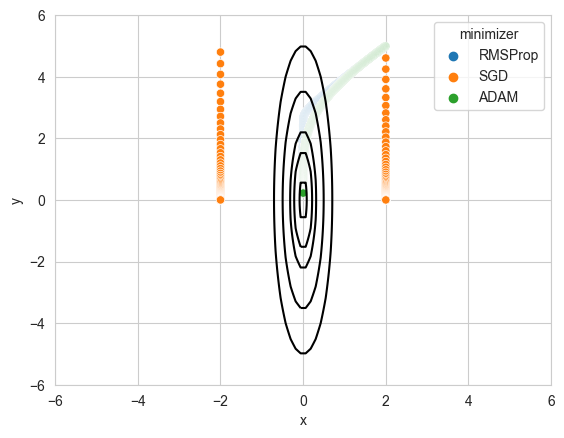

In [8]:
fig, ax = plt.subplots()
ax.contour(X, Y, Z, levels=[0, 0.1, 1, 5, 10, 25, 50], colors="black")
sns.scatterplot(x_n, x="x", y="y", hue="minimizer")

In [9]:
with tf.GradientTape() as g:
    g.watch(x)
    g.watch(y)
    t= target_fn()
    gradients = g.gradient(t, sources=[x, y])
    print(gradients) # 12, 20

[<tf.Tensor: id=307979, shape=(), dtype=float32, numpy=0.00028734957>, <tf.Tensor: id=307980, shape=(), dtype=float32, numpy=0.89035296>]
